<a href="https://colab.research.google.com/github/kamranr123/kamranr123.github.io/blob/master/SD_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> KM Colab</h1>

In [2]:
# @title ## Choose Models
import markdown
import zipfile
import shutil
import os
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from importlib import reload

# ******************************************************************************
class Modelpaths:
    base_path = '/content/models'
    model = f'{base_path}/checkpoints'
    lora = f'{base_path}/loras'
    vae = f'{base_path}/vae'
    upscale = f'{base_path}/upscale_models'
    controlnet = f'{base_path}/controlnet'
    embeddings = f'{base_path}/embeddings'
    diffusers = f'{base_path}/diffusers'

    def __init__(self):
        if not os.path.exists(self.base_path):
            os.makedirs(self.model)
            os.makedirs(self.lora)
            os.makedirs(self.vae)
            os.makedirs(self.upscale)
            os.makedirs(self.embeddings)
            os.makedirs(self.diffusers)

modelpaths = Modelpaths()

%cd /content
!apt -y install -qq aria2

def download(model_link, model_name, path = '', user=''):
    # !cd /content/gdrive/MyDrive/yourfoldername; wget civitai-link --content-disposition
    if path == '':
        path = modelpaths.model

    %cd {path}
    if path == modelpaths.model:
        !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M {model_link} --dir={path} --out={model_name} --http-user=<USER>
    else:
        !aria2c --console-log-level=error -c -x 16 -s 8 -k 1M {model_link} --dir={path} --out={model_name}
# ******************************************************************************
clear_output()

!wget -q https://github.com/kamranr123/upscaler/raw/main/upscale.py -P /content/
import upscale
reload(upscale)

# ******************************************************************************
!wget -q https://raw.githubusercontent.com/kamranr123/kamranr123.github.io/master/modellist.py -P /content/
import modellist
reload(modellist)
available_model_dict = modellist.available_model_dict
# ******************************************************************************
# initialize values
model = list(available_model_dict.keys())[0]
model_ver = available_model_dict[model][0]
model_name = available_model_dict[model][4]
model_link = available_model_dict[model][3] + model_name
if 'civitai.com' in model_link:
    model_link = available_model_dict[model][3]

# Define the title and link
title = "Model selection"
link = "https://github.com/NUROISEA/anime-webui-colab/wiki/Selecting-a-model"

# Generate the Markdown-formatted text
markdown_text = f"# {title} [**[?]**]({link})"

# Convert the Markdown text to HTML
html = markdown.markdown(markdown_text)
display(Markdown(html))

# Create a list of models for the first selection listbox
model_options = list(available_model_dict.keys())

# Create the first selection listbox widget for models
model_selection = widgets.Select(
    options=model_options,
    description='Choose a model:',
    style={'description_width': 'initial'}
)

# Create the second selection listbox widget for values
model_version_selection = widgets.Select(
    options = available_model_dict[model_options[0]][4:],
    description='Choose a model version:',
    style={'description_width': 'initial'}
)

# Define a function to handle the model selection change event
def on_model_selection_change(change):
    global model
    model = change['new']
    print('change')
    selected_values = available_model_dict[model][4:]
    model_version_selection.options = selected_values

# Attach the model selection change event handler
model_selection.observe(on_model_selection_change, 'value')

# Define a function to handle the model selection change event
def on_model_version_selection_change(change):
    global model_name, model_link, model_ver
    model_name = change['new']
    model_link = available_model_dict[model][3] + model_name
    model_ver = available_model_dict[model][0]
    if 'civitai.com' in model_link:
        model_link = available_model_dict[model][3]
    print("\r", end="")
    print("Selected Model: {}, Version: {}".format(model, model_name), end="")
    # print("Selected Model link: {}".format(model_link), end="")

# Attach the model version selection change event handler
model_version_selection.observe(on_model_version_selection_change, 'value')

# Display the selection listboxes
display(model_selection)
display(model_version_selection)
print("Selected Model: {}, Version: {}".format(model, model_name), end="")


<h1>Model selection <a href="https://github.com/NUROISEA/anime-webui-colab/wiki/Selecting-a-model"><strong>[?]</strong></a></h1>

Select(description='Choose a model:', options=('Stable Diffusion v1.5', 'Dark Sushi Mix', 'ExpMix Line', 'Cham…

Select(description='Choose a model version:', options=('v1-5-pruned.safetensors', 'v1-5-pruned-emaonly.safeten…

Selected Model: Stable Diffusion v1.5, Version: v1-5-pruned.safetensorschange
Selected Model: Dreamshaper-8-lcm, Version: Dreamshaper-8-lcm.safetensors

In [ ]:
download(model_link, model_name, modelpaths.model)

!wget -q 'https://huggingface.co/nolanaatama/colab/resolve/main/embeddings.zip' -P {modelpaths.embeddings}
with zipfile.ZipFile(f"{modelpaths.embeddings}/embeddings.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{modelpaths.base_path}")
os.remove(f"{modelpaths.embeddings}/embeddings.zip")

download('https://civitai.com/api/download/models/218471', 'blackgold-000008.safetensors', modelpaths.lora)
download('https://civitai.com/api/download/models/87153?type=Model&format=SafeTensor', 'more_details.safetensors', modelpaths.lora)


In [ ]:
!cd {modelpaths.model}
!wget https://huggingface.co/Lykon/dreamshaper-8-lcm/resolve/main/DreamShaper8_LCM.safetensors?download=true --content-disposition

# Initial

In [5]:
!pip install diffusers transformers accelerate omegaconf peft
# !pip install xformers==0.0.2
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, LCMScheduler
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline, AutoencoderKL
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
from diffusers import DPMSolverSinglestepScheduler, KDPM2DiscreteScheduler, KDPM2AncestralDiscreteScheduler
from diffusers import HeunDiscreteScheduler, LMSDiscreteScheduler, DEISMultistepScheduler, UniPCMultistepScheduler

from diffusers.utils import load_image
# example image = load_image("https://user-images.githubusercontent.com/24734142/266492875-2d50d223-8475-44f0-a7c6-08b51cb53572.png")

clear_output()

In [ ]:
# install ip-adapter
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git
# download the models
# !cd IP-Adapter
# !git lfs install
# !git clone https://huggingface.co/h94/IP-Adapter
# !mv IP-Adapter/models models
# !mv IP-Adapter/sdxl_models sdxl_models

In [ ]:
from enum import Enum
import math
import safetensors
import torch
import re

# clip_text_custom_embedder.py
# https://gist.github.com/takuma104/43552b8ec70b63323c57dc9c6fcb9b90

re_attention = re.compile(r"""
\\\(|
\\\{|
\\\)|
\\\}|
\\\[|
\\]|
\\\\|
\\|
\(|
\{|
\[|
:([+-]?[.\d]+)\)|
\)|
\}|
]|
[^\\()\\{}\[\]:]+|
:
""", re.X)


def parse_prompt_attention(text):
    """
    Parses a string with attention tokens and returns a list of pairs: text and its assoicated weight.
    Accepted tokens are:
      (abc) - increases attention to abc by a multiplier of 1.1
      (abc:3.12) - increases attention to abc by a multiplier of 3.12
      [abc] - decreases attention to abc by a multiplier of 1.1
      \( - literal character '('
      \[ - literal character '['
      \) - literal character ')'
      \] - literal character ']'
      \\ - literal character '\'
      anything else - just text
    >>> parse_prompt_attention('normal text')
    [['normal text', 1.0]]
    >>> parse_prompt_attention('an (important) word')
    [['an ', 1.0], ['important', 1.1], [' word', 1.0]]
    >>> parse_prompt_attention('(unbalanced')
    [['unbalanced', 1.1]]
    >>> parse_prompt_attention('\(literal\]')
    [['(literal]', 1.0]]
    >>> parse_prompt_attention('(unnecessary)(parens)')
    [['unnecessaryparens', 1.1]]
    >>> parse_prompt_attention('a (((house:1.3)) [on] a (hill:0.5), sun, (((sky))).')
    [['a ', 1.0],
     ['house', 1.5730000000000004],
     [' ', 1.1],
     ['on', 1.0],
     [' a ', 1.1],
     ['hill', 0.55],
     [', sun, ', 1.1],
     ['sky', 1.4641000000000006],
     ['.', 1.1]]
    """

    res = []
    round_brackets = []
    square_brackets = []

    round_bracket_multiplier = 1.1
    square_bracket_multiplier = 1 / 1.1

    def multiply_range(start_position, multiplier):
        for p in range(start_position, len(res)):
            res[p][1] *= multiplier

    for m in re_attention.finditer(text):
        text = m.group(0)
        weight = m.group(1)

        if text.startswith('\\'):
            res.append([text[1:], 1.0])
        elif text == '(' or text == '{':
            round_brackets.append(len(res))
        elif text == '[':
            square_brackets.append(len(res))
        elif weight is not None and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), float(weight))
        elif (text == ')' or text == '}') and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), round_bracket_multiplier)
        elif text == ']' and len(square_brackets) > 0:
            multiply_range(square_brackets.pop(), square_bracket_multiplier)
        else:
            res.append([text, 1.0])

    for pos in round_brackets:
        multiply_range(pos, round_bracket_multiplier)

    for pos in square_brackets:
        multiply_range(pos, square_bracket_multiplier)

    if len(res) == 0:
        res = [["", 1.0]]

    # merge runs of identical weights
    i = 0
    while i + 1 < len(res):
        if res[i][1] == res[i + 1][1]:
            res[i][0] += res[i + 1][0]
            res.pop(i + 1)
        else:
            i += 1

    return res


class CLIPTextCustomEmbedder(object):
    def __init__(self, tokenizer, text_encoder, device,
                 clip_stop_at_last_layers=1):
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.token_mults = {}
        self.device = device
        self.clip_stop_at_last_layers = clip_stop_at_last_layers

    def tokenize_line(self, line):
        def get_target_prompt_token_count(token_count):
            return math.ceil(max(token_count, 1) / 75) * 75

        id_end = self.tokenizer.eos_token_id
        parsed = parse_prompt_attention(line)
        tokenized = self.tokenizer(
            [text for text, _ in parsed], truncation=False,
            add_special_tokens=False)["input_ids"]

        fixes = []
        remade_tokens = []
        multipliers = []

        for tokens, (text, weight) in zip(tokenized, parsed):
            i = 0
            while i < len(tokens):
                token = tokens[i]
                remade_tokens.append(token)
                multipliers.append(weight)
                i += 1

        token_count = len(remade_tokens)
        prompt_target_length = get_target_prompt_token_count(token_count)
        tokens_to_add = prompt_target_length - len(remade_tokens)
        remade_tokens = remade_tokens + [id_end] * tokens_to_add
        multipliers = multipliers + [1.0] * tokens_to_add
        return remade_tokens, fixes, multipliers, token_count

    def process_text(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        remade_batch_tokens = []
        cache = {}
        batch_multipliers = []
        for line in texts:
            if line in cache:
                remade_tokens, fixes, multipliers = cache[line]
            else:
                remade_tokens, fixes, multipliers, _ = self.tokenize_line(line)
                cache[line] = (remade_tokens, fixes, multipliers)

            remade_batch_tokens.append(remade_tokens)
            batch_multipliers.append(multipliers)

        return batch_multipliers, remade_batch_tokens

    def __call__(self, text):
        batch_multipliers, remade_batch_tokens = self.process_text(text)

        z = None
        i = 0
        while max(map(len, remade_batch_tokens)) != 0:
            rem_tokens = [x[75:] for x in remade_batch_tokens]
            rem_multipliers = [x[75:] for x in batch_multipliers]

            tokens = []
            multipliers = []
            for j in range(len(remade_batch_tokens)):
                if len(remade_batch_tokens[j]) > 0:
                    tokens.append(remade_batch_tokens[j][:75])
                    multipliers.append(batch_multipliers[j][:75])
                else:
                    tokens.append([self.tokenizer.eos_token_id] * 75)
                    multipliers.append([1.0] * 75)

            z1 = self.process_tokens(tokens, multipliers)
            z = z1 if z is None else torch.cat((z, z1), axis=-2)

            remade_batch_tokens = rem_tokens
            batch_multipliers = rem_multipliers
            i += 1

        return z

    def process_tokens(self, remade_batch_tokens, batch_multipliers):
        remade_batch_tokens = [[self.tokenizer.bos_token_id] + x[:75] +
                               [self.tokenizer.eos_token_id] for x in remade_batch_tokens]
        batch_multipliers = [[1.0] + x[:75] + [1.0] for x in batch_multipliers]

        tokens = torch.asarray(remade_batch_tokens).to(self.device)
        # print(tokens.shape)
        # print(tokens)
        outputs = self.text_encoder(
            input_ids=tokens, output_hidden_states=True)

        if self.clip_stop_at_last_layers > 1:
            z = self.text_encoder.text_model.final_layer_norm(
                outputs.hidden_states[-self.clip_stop_at_last_layers])
        else:
            z = outputs.last_hidden_state

        # restoring original mean is likely not correct, but it seems to work well
        # to prevent artifacts that happen otherwise
        batch_multipliers_of_same_length = [
            x + [1.0] * (75 - len(x)) for x in batch_multipliers]
        batch_multipliers = torch.asarray(
            batch_multipliers_of_same_length).to(self.device)
        # print(batch_multipliers.shape)
        # print(batch_multipliers)

        original_mean = z.mean()
        z *= batch_multipliers.reshape(batch_multipliers.shape +
                                       (1,)).expand(z.shape)
        new_mean = z.mean()
        z *= original_mean / new_mean

        return z

    def get_text_tokens(self, text):
        batch_multipliers, remade_batch_tokens = self.process_text(text)
        return [[self.tokenizer.bos_token_id] + remade_batch_tokens[0]], \
            [[1.0] + batch_multipliers[0]]


def text_embeddings_equal_len(text_embedder, prompt, negative_prompt):
    cond_embeddings = text_embedder(prompt)
    uncond_embeddings = text_embedder(negative_prompt)

    cond_len = cond_embeddings.shape[1]
    uncond_len = uncond_embeddings.shape[1]
    if cond_len == uncond_len:
        return cond_embeddings, uncond_embeddings
    else:
        if cond_len > uncond_len:
            n = (cond_len - uncond_len) // 77
            return cond_embeddings, torch.cat([uncond_embeddings] + [text_embedder("")]*n, dim=1)
        else:
            n = (uncond_len - cond_len) // 77
            return torch.cat([cond_embeddings] + [text_embedder("")]*n, dim=1), uncond_embeddings


def text_embeddings(pipe, prompt, negative_prompt, clip_stop_at_last_layers=1):
    text_embedder = CLIPTextCustomEmbedder(tokenizer=pipe.tokenizer,
                                           text_encoder=pipe.text_encoder,
                                           device=pipe.text_encoder.device,
                                           clip_stop_at_last_layers=clip_stop_at_last_layers)
    cond_embeddings, uncond_embeddings = text_embeddings_equal_len(text_embedder, prompt, negative_prompt)
    return cond_embeddings, uncond_embeddings
# *******************************************************

def saveJPEG(image, path, name, quality=90):
    image.convert('RGB').save(f'{path}/{name}.jpg', optimize=True, quality=quality)

class SDLoader:

    class UpscalerModel(Enum):
        RealESRGAN_x2 = ['https://huggingface.co/sberbank-ai/Real-ESRGAN/resolve/main/RealESRGAN_x2.pth', 'RealESRGAN_x2.pth']
        UltraSharp_4x = ['https://huggingface.co/uwg/upscaler/resolve/main/ESRGAN/4x-UltraSharp.pth', '4x-UltraSharp.pth']

    class Scheduler(Enum):
        Euler = 1
        Euler_a = 2
        DPM_PP_2M = 3
        DPM_PP_2M_SDE = 4
        DPM_PP_SDE = 5
        DPM2 = 6
        DPM2_a = 7
        Heun = 8
        LMS = 9
        DEIS = 10
        UniPC = 11
        LCM = 12

    __device_name = "cuda"
    __torch_dtype = torch.float16
    _pipe = None

    _vae=None
    _original_vae=None
    _vae_name=None
    _scheduler_type = Scheduler.Euler

    __default_clip_skip=1
    _clip_skip = __default_clip_skip
    _model_diffuser_path=None
    __original_clip_layers=None
    _ip_adapter_image=None

    __loaded_embeddings = []
    __loaded_lora = []

    _esrgan_model=None
    _upscaler_model=None
    _upscaler_type=None
    seed = 0

    def __init__(self) -> None:
        if not torch.cuda.is_available():
            print('cuda is unavailable!')
            self.__device_name = torch.device("cpu")
            self.__torch_dtype = torch.float32
        self._upscaler_model=upscale.UpscaleModel()
        pass

    def loadModel(self, safetensors_model, clip_skip=2):
        self._model_diffuser_path = modelpaths.model + '/' + safetensors_model
        if not os.path.exists(self._model_diffuser_path):
            print(f"{safetensors_model} not found !")
            return
        if self._pipe is not None:
            print("unload the last model before continue!")
            return

        self._pipe = StableDiffusionPipeline.from_single_file(self._model_diffuser_path,
                                    torch_dtype=self.__torch_dtype, load_safety_checker=False)
        self._pipe = self._pipe.to(self.__device_name)
        # self._pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)


        self._original_vae=self._pipe.vae
        self.change_scheduler(self._scheduler_type, True)

        self.__original_clip_layers = self._pipe.text_encoder.text_model.encoder.layers
        self.setClipSkip(self._clip_skip)
        self.reload_embeddings()

    def loadVAE(self, vae_name):
        path = modelpaths.vae + '/' + vae_name
        if not os.path.exists(self.path):
            print(f"{vae_name} not found !")
            return

        if vae_name != self._vae_name:
            if (vae_name is None) and (self._vae_name is not None):
                self._pipe.vae = self._original_vae
                self._vae_name = None
            elif vae_name is not None:
                self._vae = AutoencoderKL.from_single_file(path)
                self._vae_name=vae_name
                self._pipe.vae = self._vae

    def setClipSkip(self, clip_skip):
        if self._pipe is None:
            print('no model loaded!')
            return
        self._clip_skip = clip_skip

        if clip_skip > 1:
            self._pipe.text_encoder.text_model.encoder.layers = self.__original_clip_layers[:-(clip_skip-1)]
        else:
            self._pipe.text_encoder.text_model.encoder.layers = self.__original_clip_layers

    def change_scheduler(self, scheduler: Scheduler, karras=False):
        if self._pipe is None:
            print('no model loaded!')
            return

        if scheduler == SDLoader.Scheduler.Euler:
            self._pipe.scheduler = EulerDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.Euler_a:
            self._pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM_PP_2M:
            self._pipe.scheduler = DPMSolverMultistepScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM_PP_2M_SDE:
            self._pipe.scheduler = DPMSolverMultistepScheduler.from_config(self._pipe.scheduler.config)
            self._pipe.scheduler.algorithm_type="sde-dpmsolver++"
        elif scheduler == SDLoader.Scheduler.DPM_PP_SDE:
            self._pipe.scheduler = DPMSolverSinglestepScheduler.from_config(self._pipe.scheduler.config)
            self._pipe.scheduler.algorithm_type="sde-dpmsolver++"
        elif scheduler == SDLoader.Scheduler.DPM2:
            self._pipe.scheduler = KDPM2DiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DPM2_a:
            self._pipe.scheduler = KDPM2AncestralDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.Heun:
            self._pipe.scheduler = HeunDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.LMS:
            self._pipe.scheduler = LMSDiscreteScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.DEIS:
            self._pipe.scheduler = DEISMultistepScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.UniPC:
            self._pipe.scheduler = UniPCMultistepScheduler.from_config(self._pipe.scheduler.config)
        elif scheduler == SDLoader.Scheduler.LCM:
            self._pipe.scheduler = LCMScheduler.from_config(self._pipe.scheduler.config)

        self._pipe.scheduler.use_karras_sigmas=karras

    def unload(self):
        if self._pipe is not None:
            self._pipe.maybe_free_model_hooks()
            self._pipe.unload_lora_weights()
            self._pipe = None
            self._model_diffuser_path=None
            self.__loaded_embeddings=[]
            self.__original_clip_layers=None
            self.clip_skip=self.__default_clip_skip
            self._vae=None
            self._original_vae=None
            self._vae_name=None

    def __extract_filename(self, full_path):
        filename = os.path.basename(full_path)
        return os.path.splitext(filename)[0]

    def __read_file_list(self, directory, extension):
        file_list = []
        for filename in os.listdir(directory):
            for ext in extension.split('|'):
                if filename.endswith(ext):
                    file_list.append(filename)
        return file_list

    def reload_embeddings(self):
        print('reload_embeddings')
        if self._pipe is None:
            print('no model loaded!')
            return

        current_file_list = self.__read_file_list(modelpaths.embeddings, '.pt|.bin|.safetensors')
        for embeddingsfile in current_file_list:
            if embeddingsfile not in self.__loaded_embeddings:
                try:
                    self._pipe.load_textual_inversion(modelpaths.embeddings + '/' + embeddingsfile, token=self.__extract_filename(embeddingsfile))
                    self.__loaded_embeddings.append(embeddingsfile)
                except Exception as e:
                    print(f'error loading {embeddingsfile}')

        print('finish reload_embeddings: total loaded = ' + str(len(self.__loaded_embeddings)))

    def runText2Img(self, prompt, negative_prompt, step=20, gs=6, w=512, h=512, batch=1):
        if self._pipe is None:
            print('no model loaded!')
            return

        p, np = text_embeddings(self._pipe, prompt, negative_prompt, clip_stop_at_last_layers=self._clip_skip)

        image = self._pipe(prompt_embeds=p, negative_prompt_embeds=np, ip_adapter_image=self._ip_adapter_image, generator=torch.manual_seed(self.seed),
            height=h, width=w, guidance_scale=gs, num_inference_steps=step, num_images_per_prompt=batch).images

        return image

    def runImg2Img(self, prompt, negative_prompt, image, strength=0.35, step=20, gs=6, batch=1):
        if self._pipe is None:
            print('no model loaded!')
            return

        components = self._pipe.components
        img2img_pipe = StableDiffusionImg2ImgPipeline(**components)

        p, np = text_embeddings(img2img_pipe, prompt, negative_prompt, clip_stop_at_last_layers=self._clip_skip)

        images = img2img_pipe(prompt_embeds=p, negative_prompt_embeds=np, generator=torch.manual_seed(self.seed),
            strength=strength, image=image, guidance_scale=gs, num_inference_steps=step, num_images_per_prompt=batch).images

        img2img_pipe = None
        return images

    def apply_lora(self, filename, alpha=1.0):
        if self._pipe is None:
            print('no model loaded!')
            return
        lora = modelpaths.lora + '/' + filename
        if not os.path.exists(lora):
            print(f"{filename} not found !")
            return

        change = False
        found = False
        lora_file_name = filename.split('.')[0]
        for i in range(len(self.__loaded_lora)):
            la = self.__loaded_lora[i]
            if la[0] == lora_file_name:
                found = True
                if la[0] != alpha:
                    self.__loaded_lora[i][1] = alpha
                    change = True
                break

        if not found:
            self._pipe.load_lora_weights(".", weight_name=lora, adapter_name=lora_file_name)
            self.__loaded_lora.append([lora_file_name, alpha])
            change = True

        if change:
            lora_list = []
            lora_weights_list = []
            for i in range(len(self.__loaded_lora)):
                la = self.__loaded_lora[i]
                if la[1] != 0:
                    lora_list.append(la[0])
                    lora_weights_list.append(la[1])
            self._pipe.set_adapters(lora_list, adapter_weights=lora_weights_list)

    def remove_lora(self, filename):
        # if self._pipe is None:
        #     print('no model loaded!')
        #     return
        # lora_file_name = filename.split('.')[0]

        # for i in range(len(self.__loaded_lora)):
        #     la = self.__loaded_lora[i]
        #     if la[0] == lora_file_name:
        #         self.__loaded_lora.remove(la)
        self.apply_lora(filename, 0)

    def scaleImageBy(self, images, scale_factor, type='bicubic'):
        image_tensor = self._upscaler_model.convert_PIL_Image_to_torch_tensor(images)
        im = self._upscaler_model.upscale(image_tensor, type, scale_factor)
        return self._upscaler_model.convert_torch_tensor_to_PIL_Image(im)

    def scaleImageByModel(self, images, model : UpscalerModel = UpscalerModel.RealESRGAN_x2):
        esrgan_model = None
        if model == SDLoader.UpscalerModel.RealESRGAN_x2:
            if self._upscaler_type != SDLoader.UpscalerModel.RealESRGAN_x2:
                if not os.path.exists(modelpaths.upscale + '/' + SDLoader.UpscalerModel.RealESRGAN_x2.value[1]):
                    download(SDLoader.UpscalerModel.RealESRGAN_x2.value[0], SDLoader.UpscalerModel.RealESRGAN_x2.value[1], modelpaths.upscale)
                    if not os.path.exists(modelpaths.upscale + '/' + SDLoader.UpscalerModel.RealESRGAN_x2.value[1]):
                        raise Exception('SDLoader.scaleImageByModel: download RealESRGAN_x2 failed!')

                _upscaler_type=SDLoader.UpscalerModel.RealESRGAN_x2
                self._esrgan_model = self._upscaler_model.load_model(modelpaths.upscale + '/' + SDLoader.UpscalerModel.RealESRGAN_x2.value[1])

        elif model == SDLoader.UpscalerModel.UltraSharp_4x:
            if self._upscaler_type != SDLoader.UpscalerModel.UltraSharp_4x:
                if not os.path.exists(modelpaths.upscale + '/' + SDLoader.UpscalerModel.UltraSharp_4x.value[1]):
                    download(SDLoader.UpscalerModel.UltraSharp_4x.value[0], SDLoader.UpscalerModel.UltraSharp_4x.value[1], modelpaths.upscale)
                    if not os.path.exists(modelpaths.upscale + '/' + SDLoader.UpscalerModel.UltraSharp_4x.value[1]):
                        raise Exception('SDLoader.scaleImageByModel: download 4x-UltraSharp failed!')

                _upscaler_type=SDLoader.UpscalerModel.UltraSharp_4x
                self._esrgan_model = self._upscaler_model.load_model(modelpaths.upscale + '/' + SDLoader.UpscalerModel.UltraSharp_4x.value[1])
        else:
            raise Exception('SDLoader.scaleImageByModel: model not supported!')

        image_tensor = self._upscaler_model.convert_PIL_Image_to_torch_tensor(images)
        im = self._upscaler_model.upscale_by_model(self._esrgan_model, image_tensor)
        return self._upscaler_model.convert_torch_tensor_to_PIL_Image(im)

    class ControlnetModel(Enum):
        Canny = ['https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_canny.fp16.safetensors']
        Depth = ['https://huggingface.co/lllyasviel/control_v11f1p_sd15_depth/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11f1p_sd15_depth.fp16.safetensors']
        SoftEdge = ['https://huggingface.co/lllyasviel/control_v11p_sd15_softedge/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_softedge.fp16.safetensors']
        Inpaint = ['https://huggingface.co/lllyasviel/control_v11p_sd15_inpaint/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_inpaint.fp16.safetensors']
        OpenPose = ['https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_openpose.fp16.safetensors']
        Scribble = ['https://huggingface.co/lllyasviel/control_v11p_sd15_scribble/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_scribble.fp16.safetensors']
        LineArt  = ['https://huggingface.co/lllyasviel/control_v11p_sd15_lineart/resolve/main/diffusion_pytorch_model.fp16.safetensors?download=true', 'control_v11p_sd15_lineart.fp16.safetensors']

    def applyControlnet(self, model : ControlnetModel, src_image, strength=1):
        if self._pipe is None:
            print('no model loaded!')
            return
        cnet_path = modelpaths.controlnet + '/' + model.value[1]
        download(model.value[0], model.value[1], modelpaths.controlnet)
        if not os.path.exists(cnet_path):
            raise Exception(f'SDLoader.applyControlnet: download {model.value.name} failed!')

        TODO('')
        # controlnet = ControlNetModel.from_single_file(url)
        # pipe = StableDiffusionControlNetPipeline.from_single_file(url, controlnet=controlnet)
        # https://github.com/huggingface/diffusers/pull/2407#issuecomment-1451951059
        # pipe.controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-normal", torch_dtype=torch.float16)

    def getPip(self):
        return self._pipe

    def applyIPAdapter(self, image, scale=0.6):
        self._pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter-full-face_sd15.bin")
        self._pipe.set_ip_adapter_scale(scale)
        self._ip_adapter_image=image


sdloader = SDLoader()
sdloader.loadModel('DreamShaper8_LCM.safetensors')

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/8 [00:00<?, ?it/s]

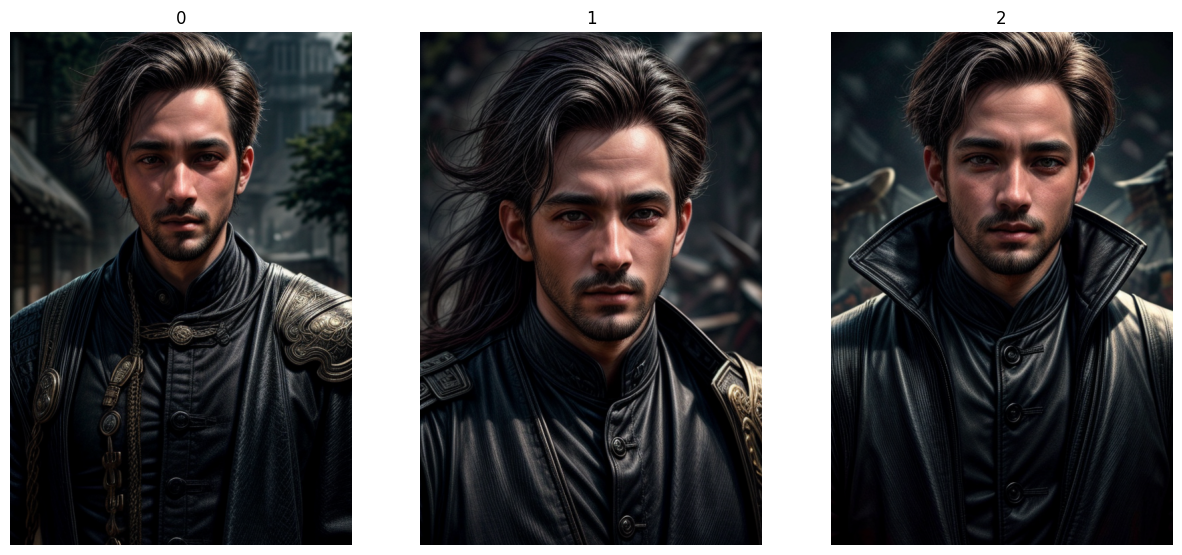

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_images(images, labels = None):
    N = len(images)
    n_cols = 3
    n_rows = int(np.ceil(N / n_cols))

    if images[0].width > images[0].height:
        plt.figure(figsize = (7 * n_cols, 5 * n_rows))
    else:
        plt.figure(figsize = (5 * n_cols, 7 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        if labels is not None:
            plt.title(labels[i])
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()

prompt = """realistic fantastic man warriors, king, highly detailed liny black gold suit,
        fantasy war background, highly detailed eyes, highly detailed realistic face skin, enhanced, 8k"""

negative_prompt="(worst quality, low quality:1.4), FastNegativeEmbedding, bad-hands-5, asian"
sdloader.seed=26553316
sdloader.change_scheduler(SDLoader.Scheduler.LCM)
sdloader.setClipSkip(2)
# sdloader.apply_lora('blackgold-000008.safetensors', 0.2)
sdloader.apply_lora('more_details.safetensors', 1.2)
images = sdloader.runText2Img(prompt, negative_prompt, 8, 1.5, 512, 768, 3)
# sdloader.remove_lora(c)
plot_images(images, range(len(images)))

  0%|          | 0/8 [00:00<?, ?it/s]

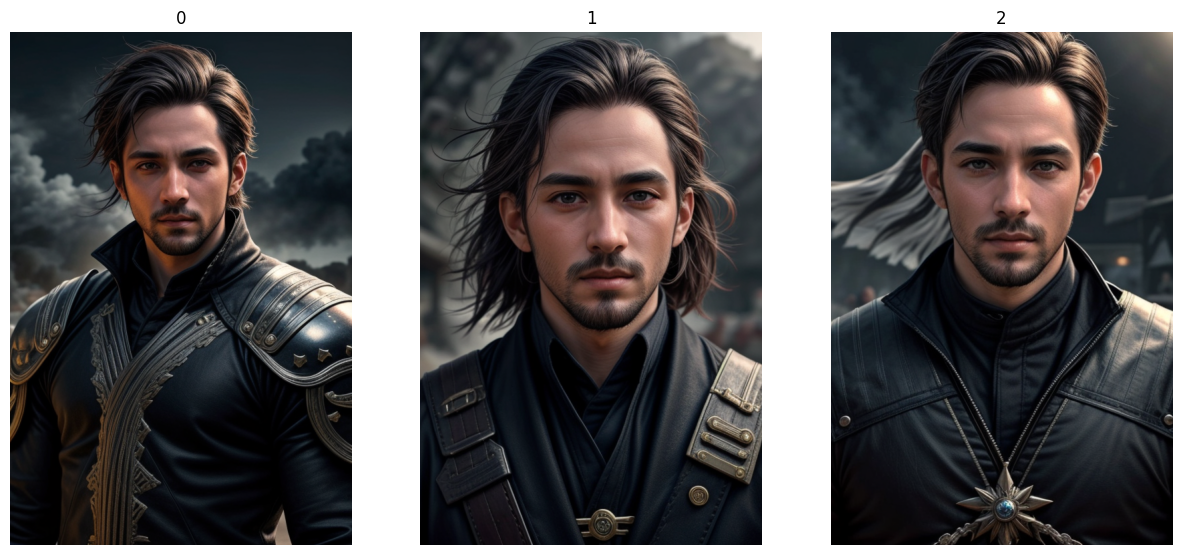

In [30]:
limg = Image.open('/content/me.jpg')
sdloader.applyIPAdapter(limg, scale =0.4)
images = sdloader.runText2Img(prompt, negative_prompt, 8, 1.5, 512, 768, 3)
plot_images(images, range(len(images)))

In [ ]:
sr_images = sdloader.scaleImageByModel(images, SDLoader.UpscalerModel.UltraSharp_4x)
sr_images = sdloader.scaleImageBy(sr_images, 0.7, type='bicubic')


In [ ]:
prompt2 = prompt + ''
images2 = sdloader.runImg2Img(prompt2, negative_prompt, sr_images[2], strength=0.4, step=40, gs=8, batch=1)
saveJPEG(images2[0], '/content/out', 'wm3')
plot_images(images2, range(len(images2)))

In [ ]:
sdloader.unload()
sdloader = None